# Important Notice:

Since I re-trained this many times, in this final ipynb file, I will only run all training for 5 epoch to prove I do not report wrong numbers of them. 

Also, I will not de the data generation task in part two since I have done it and the result is shown on my reoprt.
If you want to check if it works or not, please change the variable `train_type` to `"part2_augment"`. This will lead the file only runs the generation, which will save the time.

Moreover, the warning message under the training block of model1 is because the memory limitation since I train it in my computer. This warning does not effect the training and the result is just under the bottom of all outputs.

In [1]:
train_type = "final"

# Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

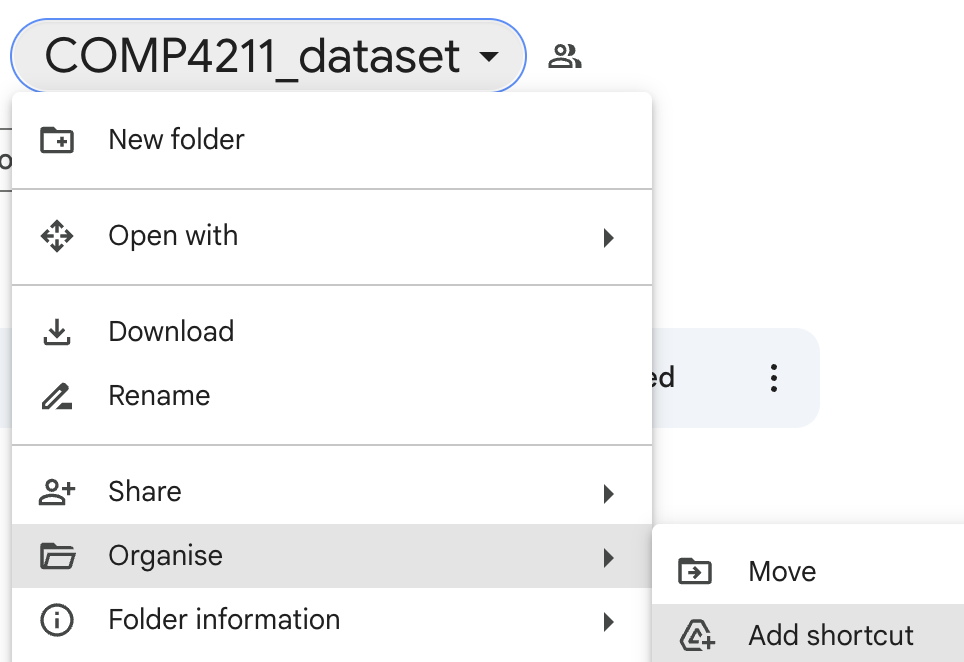

Mount the dataset by the following code (requires authorization):

In [2]:
# from google.colab import drive
import os
import warnings
import glob

warnings.filterwarnings('ignore') 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#drive.mount('/content/drive')
data_path = "./data_set"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"
is_get_image = False

To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [3]:
if not os.path.exists(wikiart_path):
    !unzip "$wikiart_zip" > /dev/null 2>&1
print("Wikiart dataset is ready")
if not os.path.exists(coco_path):
    !unzip "$coco_zip" > /dev/null 2>&1
print("COCO dataset is ready")

Wikiart dataset is ready
COCO dataset is ready


(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [4]:
# Put the PACS files in a subfolder
if not os.path.exists(pacs_path):
    !mkdir -p "$pacs_path"
    !unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [5]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm import tqdm
import cv2

# Other utility
import datetime
import psutil

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [6]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [7]:
# [C1]
class ImageDataset:
    def __init__(self, dir_path, batch_size=16, file_type="jpg", random_state = 4211):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.file_type = file_type
        self.random_state = random_state
        self.image_paths = find_images(self.dir_path, self.file_type)
        self.pointer = 0
        self.reset_pointer(seed=self.random_state)

    def get_batch(self):
        if self.pointer + self.batch_size > len(self.image_paths):
            self.reset_pointer()
            return None
        else:
            batch_paths = self.image_paths[self.pointer:self.pointer+self.batch_size]

        batch_images = [get_image(img_path) for img_path in batch_paths]
        batch_images = preprocess(np.array(batch_images))

        self.pointer += self.batch_size
        if self.pointer >= len(self.image_paths):
            self.reset_pointer()
            
        return batch_images
        
    def reset_pointer(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.pointer = 0
        np.random.shuffle(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

In [8]:
data_coco = ImageDataset(coco_path)
print(f"Number of images in COCO dataset: {len(data_coco)}")

data_wikiart = ImageDataset(wikiart_path)
print(f"Number of images in WikiArt dataset: {len(data_wikiart)}")

Number of images in COCO dataset: 3557
Number of images in WikiArt dataset: 7492


In [9]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

pic_2524.jpg	sketch	dog
pic_888.jpg	sketch	dog
pic_1279.jpg	sketch	dog
pic_2694.jpg	sketch	dog
pic_79.jpg	sketch	dog
pic_650.jpg	sketch	dog
pic_2095.jpg	sketch	dog
pic_481.jpg	sketch	dog
pic_332.jpg	sketch	dog
pic_1417.jpg	sketch	dog


In [10]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=16, random_state=4211):
        self.tsv_path = tsv_path
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.random_state = random_state
        self.index = self._process_tsv(self.tsv_path, self.dir_path)
        self.image_paths = find_images(self.dir_path, 'jpg')
        self.pointer = 0
        self.reset_pointer(seed=self.random_state)
        self.all_labels = self.index['label_animal'].unique()

    def _process_tsv(self, tsv_path, dir_path):
        column_names = ['image', 'label_type', 'label_animal']
        df = pd.read_csv(tsv_path, sep='\t', names=column_names, header=None)
        df['image'] = df['image'].apply(lambda x: os.path.join(dir_path, x))
        return df


    def add_data(self, tsv_path, dir_path):
        new_data = self._process_tsv(tsv_path, dir_path)
        self.index = pd.concat([self.index, new_data])
        new_paths = find_images(dir_path, 'jpg')
        self.image_paths = np.concatenate([self.image_paths, new_paths])

    def reset_pointer(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.pointer = 0
        np.random.shuffle(self.image_paths)

    def get_batch(self):
        if self.pointer + self.batch_size > len(self.image_paths):
            self.reset_pointer()
            return None
        else:
            batch_paths = self.image_paths[self.pointer:self.pointer+self.batch_size]
        
        # print(batch_paths)
        self.index['basename'] = self.index['image'].apply(lambda x: os.path.basename(x))
        batch_basenames = [os.path.basename(path) for path in batch_paths]
        basename_df = pd.DataFrame({'basename': batch_basenames, 'path': batch_paths})

        matched_labels = self.index.set_index('basename').loc[basename_df['basename']].reset_index()
        matched_labels['path'] = basename_df['path']
        matched_labels.set_index('path', inplace=True)
        matched_labels = matched_labels.loc[batch_paths]

        batch_images = [get_image(img_path) for img_path in batch_paths]
        batch_images = np.array(batch_images)
        batch_images = preprocess(batch_images)

        batch_labels = matched_labels[['label_animal']]

        batch_labels_encoded = np.zeros((len(batch_labels), len(self.all_labels)))
        for i, label in enumerate(batch_labels['label_animal']):
            label_index = list(self.all_labels).index(label)
            batch_labels_encoded[i, label_index] = 1

        self.pointer += self.batch_size
        if self.pointer >= len(self.image_paths):
            self.reset_pointer()

        return batch_images, batch_labels_encoded #, batch_labels
        

    def __len__(self):
        return len(self.image_paths)
        

In [11]:
data_pacs_train = ClassificationDataset(os.path.join(pacs_path, 'train-data.tsv'), os.path.join(pacs_path, 'train-files'), batch_size=60)
print(f"Number of images in PACS train dataset: {len(data_pacs_train)}")

data_pacs_test = ClassificationDataset(os.path.join(pacs_path, 'test-data.tsv'), os.path.join(pacs_path, 'test-files'), batch_size=8)
print(f"Number of images in PACS test dataset: {len(data_pacs_test)}")

#batch_images_1, batch_labels_1_en, batch_labels_1 = data_pacs_train.get_batch()
#batch_images_2, batch_labels_2_en, batch_labels_2 = data_pacs_train.get_batch()
#batch_images_3, batch_labels_3_en, batch_labels_3 = data_pacs_train.get_batch()

#print(f"Batch 1 images shape: {batch_images_1.shape}")
#print(f"Batch 1 labels shape: {batch_labels_1.shape}")
#varify_labels_1 = np.argmax(batch_labels_1_en, axis=1)
#print(f"Batch 1 labels: {batch_labels_1}")
#print(f"Batch 1 labels_encoded: {batch_labels_1_en}")
#print(f"Batch 1 labels_varify: {varify_labels_1}")

#print(f"Batch 2 images shape: {batch_images_2.shape}")
#print(f"Batch 2 labels shape: {batch_labels_2.shape}")
#print(f"Batch 2 labels: {batch_labels_2}")
#print(f"Batch 2 labels_encoded: {batch_labels_2_en}")

#print(f"Batch 3 images shape: {batch_images_3.shape}")
#print(f"Batch 3 labels shape: {batch_labels_3.shape}")
#print(f"Batch 3 labels: {batch_labels_3}")
#print(f"Batch 3 labels_encoded: {batch_labels_3_en}")



Number of images in PACS train dataset: 1641
Number of images in PACS test dataset: 2723


## Part 1: Style Transfer


### Model Components

In [12]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [13]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool3'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))

    # [C4] Load in weights and freeze the model
    weights_path = './data_set/vgg19.npz'  
    weights = np.load(weights_path, allow_pickle=True)
    index = 0

    for _ , layer in enumerate(model.layers):
        if 'conv' in layer.name:
            weights_key = 'arr_%d' % (2*index)
            biases_key = 'arr_%d' % (2*index + 1)
            index += 1
            
            kernel = weights[weights_key]
            bias = weights[biases_key]
            

            kernel = kernel.transpose([2, 3, 1, 0])
            
            kernel = kernel.astype(np.float32)
            bias = bias.astype(np.float32)
            
            layer.set_weights([kernel, bias])

    model.trainable = False

    return model

def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
    return Sequential([
        Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        UpSampling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(3, (3, 3), padding='same')
    ])


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)

    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


In [14]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [15]:
# [C6]
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 10, save_interval = 5, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay= 5e-5)

    # Calculate the number of batches per epoch
    n_batches = len(content_ds) // content_ds.batch_size

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        content_ds.reset_pointer()
        style_ds.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            content_batch = content_ds.get_batch()
            style_batch = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.
            with tf.GradientTape() as tape:
                out, adain = model([content_batch, style_batch, alpha])
                loss, content_loss, style_loss = loss_fn([content_batch, style_batch], [out, adain])

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            # Update Loss Metrics
            total_loss_sum = losses["total"] * i + loss.numpy()
            content_loss_sum = losses["content"] * i + content_loss.numpy()
            style_loss_sum = losses["style"] * i + style_loss.numpy()
            
            losses["total"] = total_loss_sum / (i + 1)
            losses["content"] = content_loss_sum / (i + 1)
            losses["style"] = style_loss_sum / (i + 1)
            



            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        print(f"Epoch {e}/{n_epochs}\t" + string)
        if e % save_interval == 0:
            if os.path.exists(save_path):
                model.save(save_path)
                print(f"Model saved at {save_path}")
            else:
                print("No save path provided. Model will not be saved.")
                
        pbar.close()

### Model setup

In [16]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 2.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [17]:
content_ds, style_ds = part1_prepare_datasets()

We can now start the training:

In [18]:
model, loss = part1_setup()
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = "./saved_model" # Change to your own path.

if not os.path.exists(PART1_SAVE_PATH):
    os.makedirs(PART1_SAVE_PATH)

In [19]:
# since i re-train the model, i will not run this part in final version
#i f train_type == "part1_train" or train_type == "final":
#    part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH)

In [20]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = './saved_model' # Change to your own path
if train_type == "part1_continue" or train_type == "final":
    part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

  0%|          | 0/222 [00:00<?, ?it/s]

2024-03-17 23:28:00.480481: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4782555152 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 1587806208/12590120960
2024-03-17 23:28:00.480508: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10441981952
InUse:                      8845686424
MaxInUse:                   9594893992
NumAllocs:                        1131
MaxAllocSize:                749207568
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-17 23:28:00.480521: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-03-17 23:28:00.480524: E tensorflow/compiler/xla/stream_exe

Epoch 1/5	total loss: 13208.481	content loss: 8125.815	style loss: 5082.665	


Epoch 2/5	total loss: 12637.676	content loss: 7726.285	style loss: 4911.391	:  10%|▉         | 22/222 [00:20<03:05,  1.08it/s]2024-03-17 23:32:03.719443: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 537755664 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 153485312/12590120960
2024-03-17 23:32:03.719474: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10441981952
InUse:                      8335462100
MaxInUse:                  10517130708
NumAllocs:                      284291
MaxAllocSize:               5088280592
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-17 23:32:03.719486: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (a

Epoch 2/5	total loss: 12974.233	content loss: 8046.959	style loss: 4927.274	


Epoch 3/5	total loss: 12338.338	content loss: 7399.719	style loss: 4938.619	:   3%|▎         | 6/222 [00:05<03:28,  1.03it/s]2024-03-17 23:35:19.948012: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 448004112 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 319094784/12590120960
2024-03-17 23:35:19.948054: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10441981952
InUse:                      9649312212
MaxInUse:                  10517130708
NumAllocs:                      522262
MaxAllocSize:               5088280592
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-17 23:35:19.948072: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (al

Epoch 3/5	total loss: 13357.402	content loss: 8183.614	style loss: 5173.788	


Epoch 4/5	total loss: 12642.970	content loss: 7832.011	style loss: 4810.959	:  18%|█▊        | 40/222 [00:37<02:50,  1.07it/s]2024-03-17 23:39:22.462326: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 537755664 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 173211648/12590120960
2024-03-17 23:39:22.462355: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10441981952
InUse:                      8335462100
MaxInUse:                  10517130708
NumAllocs:                      818320
MaxAllocSize:               5088280592
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-17 23:39:22.462367: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (a

Epoch 4/5	total loss: 12692.623	content loss: 7886.791	style loss: 4805.833	


Epoch 5/5	total loss: 12753.609	content loss: 7996.100	style loss: 4757.509	:  16%|█▌        | 35/222 [00:33<02:54,  1.07it/s]2024-03-17 23:42:47.730556: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 537755664 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 542310400/12590120960
2024-03-17 23:42:47.730585: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10441981952
InUse:                      8335462100
MaxInUse:                  10517130708
NumAllocs:                     1069153
MaxAllocSize:               5088280592
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-17 23:42:47.730598: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (a

Epoch 5/5	total loss: 12832.387	content loss: 7974.505	style loss: 4857.882	


Epoch 5/5	total loss: 12832.387	content loss: 7974.505	style loss: 4857.882	: 100%|██████████| 222/222 [03:31<00:00,  1.05it/s]

Model saved at ./saved_model


Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [21]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
  model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

  # Get content image
  
  content = get_image(content_path,resize=False)
  content = np.array(content)
  content = preprocess(content)

  # Get style image
  style = get_image(style_path)
  style = np.array(style)
  style = preprocess(style)

  # Set alpha Value
  alpha = np.array([alpha])

  # Do inference
  out, _ = model.predict([content[None, ...], style[None, ...], alpha])

  # Convert output array to image
  img = deprocess(out.squeeze())
  img = array_to_img(img)

  # Display the image in the Notebook
  display(img)
  
  # Save the image to disk
  save_path = './part1_inference_output'
  
  if not os.path.exists(save_path):
      os.makedirs(save_path)
      
  content_name = os.path.basename(content_path)
  content_name = os.path.splitext(content_name)[0]
  
  style_name = os.path.basename(style_path)
  style_name = os.path.splitext(style_name)[0]
  
  img.save(os.path.join(save_path, f'output_{content_name}_{style_name}.jpg'))

1/1 [==============================] - 0s 389ms/step


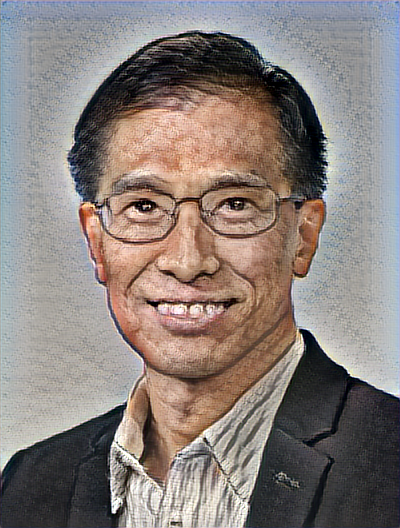

In [22]:
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = './wikiart/Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg'

part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

1/1 [==============================] - 0s 486ms/step


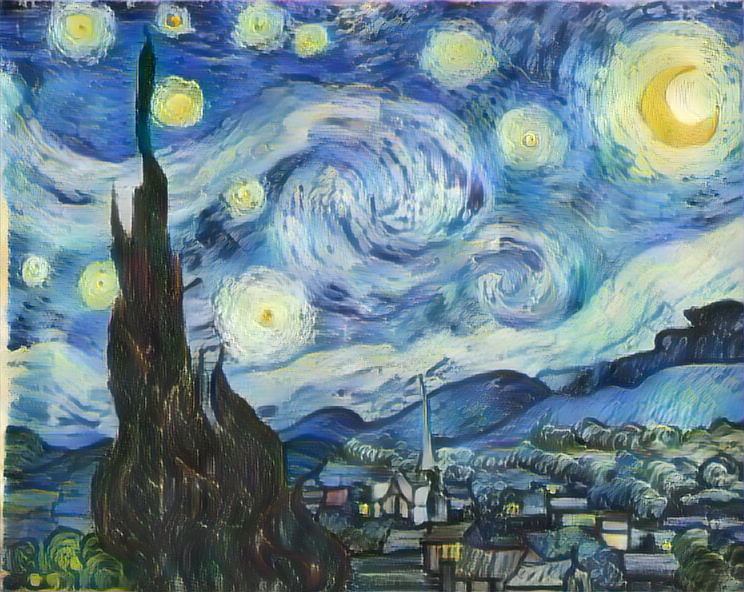

In [23]:
# Another sample, please change and test on your own
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

In [24]:
if is_get_image == True:
    for _ in range(10): 
        # Get all content images
        content_paths = glob.glob(os.path.join(data_path, 'HKUST', '*.jpg'))
        content_paths += glob.glob(os.path.join(data_path, 'HKUST', '*.jpeg'))

        # Get all style images
        style_paths = glob.glob(os.path.join('./wikiart', '*', '*.jpg'))

        # For each content image, do inference with a random style image
        for content_path in content_paths:
            style_path = random.choice(style_paths)
            part1_inference(MODEL_PATH, content_path, style_path, ALPHA)

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [25]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

Find out the distribution of images in diferent styles and categories:

label_animal
giraffe     265
dog         262
elephant    256
house       251
person      247
horse       210
guitar      150
Name: count, dtype: int64


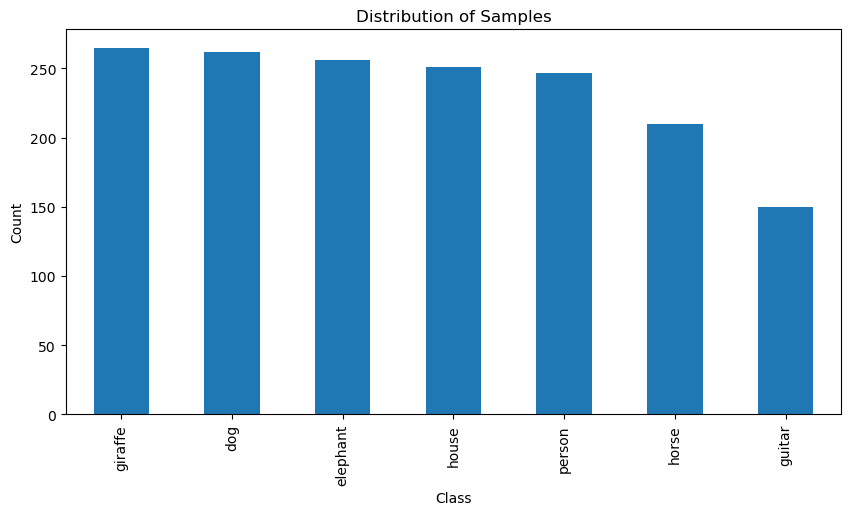

In [26]:
# [C8]
def part2_tally_samples(dataset):
    # Count the number of samples for each class
    class_counts = dataset.index['label_animal'].value_counts()
    print(class_counts)

    # Plot the distribution of samples
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title('Distribution of Samples')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    if not os.path.exists('./pic'):
        os.makedirs('./pic')
    plt.savefig(f'./pic/class_distribution_{len(dataset)}.png')
    
    plt.show()

part2_tally_samples(train_ds)

Compare this to the test dataset:

label_animal
giraffe     425
person      413
dog         407
house       386
horse       382
elephant    370
guitar      340
Name: count, dtype: int64


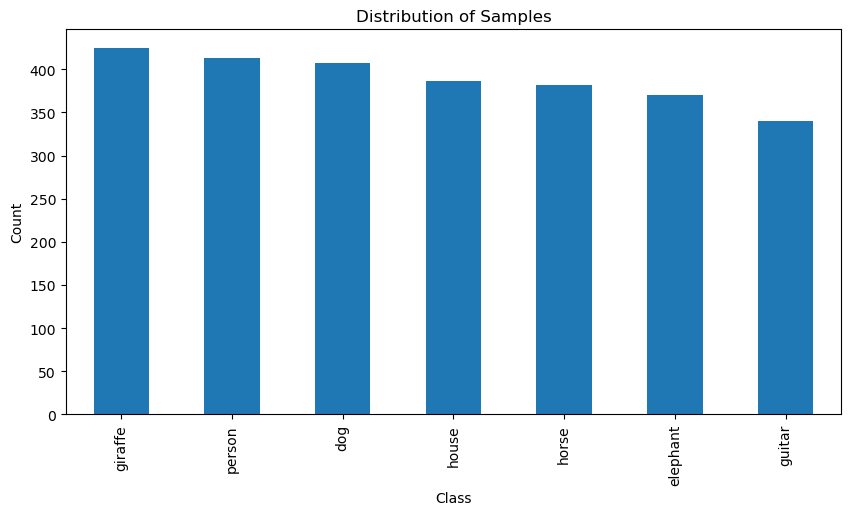

In [27]:
part2_tally_samples(test_ds)

### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [28]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure
    model = Sequential()
    
    model.add(GlobalAveragePooling2D(input_shape=input_shape, name='global_pool'))
    model.add(Dense(1024, activation='relu', name='dense1'))
    model.add(Dense(1024, activation='relu', name='dense2'))
    model.add(Dense(512, activation='relu', name='dense3'))
    model.add(Dense(num_class, activation='softmax', name='dense4'))

    return model

In [29]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_setup(load_path = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    model = build_vgg19_classifier(INPUT_SHAPE, 7)
    
    # Get Loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    if load_path:
        model.load_weights(load_path)

    return model, loss_fn

model2, loss2 = part2_setup()

### Training the model with the given dataset

In [30]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # Calculate the number of batches per epoch
    n_batches = len(dataset) // dataset.batch_size

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        dataset.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            batch_images, batch_labels = dataset.get_batch()
            
            # Execute Batch Training
            with tf.GradientTape() as tape:
                logits = model(batch_images)
                loss = loss_fn(batch_labels, logits)
                
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Update Loss Metrics
            losses["cross-entropy"] = (losses["cross-entropy"] * i + loss.numpy()) / (i + 1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)


In [31]:
# Train the model
PART2_SAVE_PATH = "./classify_saved" # [Change to your own path]
PART2_LOAD_PATH = './classify_saved' 

if not os.path.exists(PART2_SAVE_PATH):
    os.makedirs(PART2_SAVE_PATH)
    
# [Call your train function here]
train_ds = data_pacs_train
model2, loss2 = part2_setup(load_path=PART2_LOAD_PATH)

In [32]:
if train_type == "part2_train" or train_type == "final":
    part2_train(model2, train_ds, loss2, n_epochs=10,save_interval = 20, save_path=PART2_SAVE_PATH, load_path=PART2_LOAD_PATH)

Epoch 10/10	cross-entropy loss: 0.755	: 100%|██████████| 27/27 [00:01<00:00, 15.56it/s]


### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [45]:
# [C11]
def part2_evaluate(model, dataset):
    n_batches = len(dataset) // dataset.batch_size

    accuracies = []
    confusion_matrix = np.zeros((7, 7))
    
    dataset.reset_pointer()
    
    for i in range(n_batches):
        batch_images, batch_labels = dataset.get_batch()
        if batch_images is None:
            break

        logits = model(batch_images)
        predictions = np.argmax(logits, axis=1)
        true_labels = np.argmax(batch_labels, axis=1)
        
        for j in range(len(predictions)):
            confusion_matrix[true_labels[j], predictions[j]] += 1
            if predictions[j] != true_labels[j]:
                np.random.seed(4211)
                if np.random.rand() < 0.01:
                    img = deprocess(batch_images[j])
                    img = array_to_img(img)                    
                    img.save(f'./pic/misclassified_r{true_labels[j]}_p{predictions[j]}_{len(dataset)}.jpg')

        accuracy = np.mean(predictions == true_labels)
        # print(f"Batch {i+1}/{n_batches}\tAccuracy: {accuracy:.3f}")
        accuracies.append(accuracy)
        
    if not os.path.exists('./pic'):
        os.makedirs('./pic')
    plt.figure(figsize=(10, 10))
    plt.imshow(confusion_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if os.path.exists(f'./pic/confusion_matrix_{len(dataset)}.png'):
        plt.savefig(f'./pic/confusion_matrix_{len(dataset)}_1.png')
    else:
        plt.savefig(f'./pic/confusion_matrix_{len(dataset)}.png')
    plt.close()
    
    accuracies = np.array(accuracies)
    if not os.path.exists('./acc'):
        os.makedirs('./acc')
    if os.path.exists(f'./acc/accuracies_{len(dataset)}.npy'):
        np.save(f'./acc/accuracies_{len(dataset)}_1.npy', accuracies)
    else:
        np.save(f'./acc/accuracies_{len(dataset)}.npy', accuracies)
        
    if os.path.exists(f'./acc/confusion_matrix.npy_{len(dataset)}.npy'):
        np.save(f'./acc/confusion_matrix.npy_{len(dataset)}_1', confusion_matrix)
    else:
        np.save(f'./acc/confusion_matrix.npy_{len(dataset)}', confusion_matrix)
        
    return accuracies, confusion_matrix

Accuracy for Train: 0.690
Confusion Matrix for Train: [[240.   0.   8.   2.   5.   4.   2.]
 [216.  25.   5.   1.   5.   1.   2.]
 [ 10.   3. 187.  27.  13.  12.  11.]
 [ 17.   3.  13. 108.   2.   2.   1.]
 [ 10.   0.  29.   5. 137.  10.  15.]
 [ 13.   0.   9.   1.   4. 216.   2.]
 [ 13.   0.   9.   4.   8.   6. 204.]]


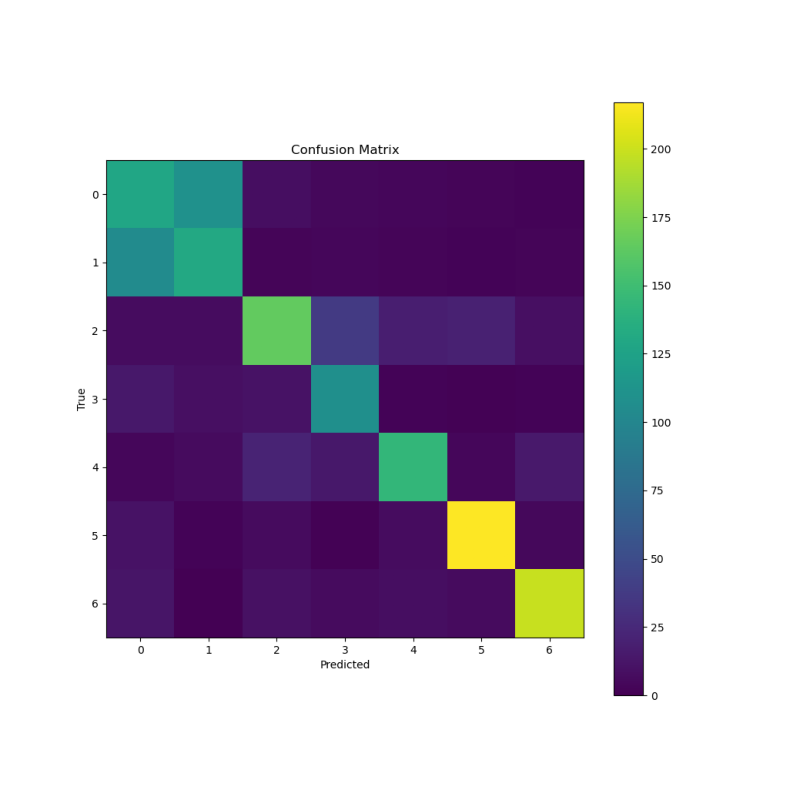

Accuracy for Test: 0.250
Confusion Matrix for Test: [[122.   2.  76.  49.  54.  61.  43.]
 [127.  21.  51.  44.  48.  44.  34.]
 [104.   4. 118.  92.  29.  54.  23.]
 [103.   6.  44.  81.  47.  20.  39.]
 [110.   3.  66.  37.  87.  48.  30.]
 [ 86.   7.  74.  23.  31. 142.  23.]
 [123.   7.  72.  27.  48.  26. 110.]]


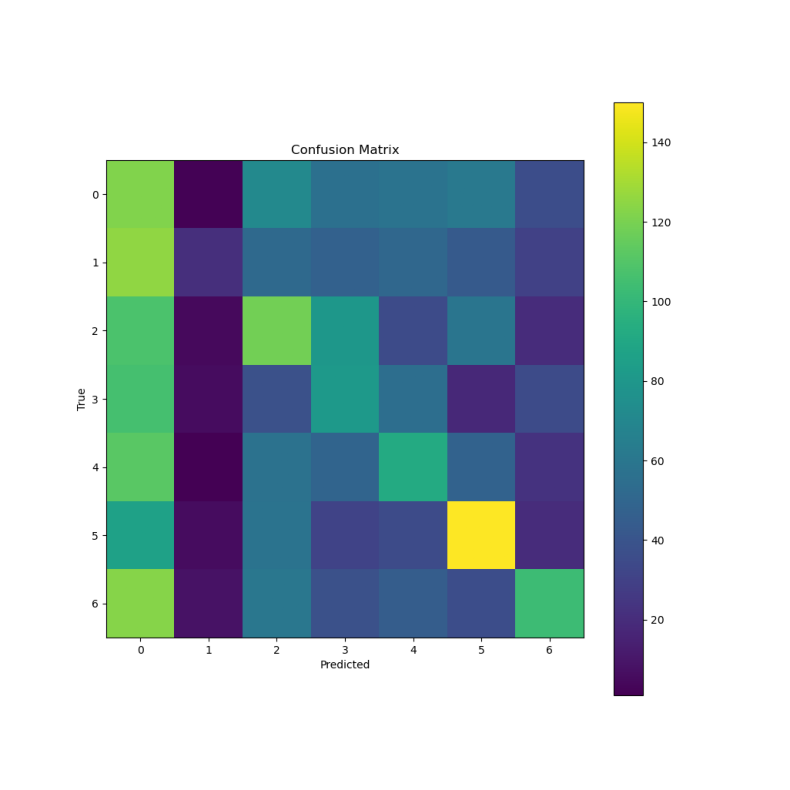

In [47]:
# Evaluate the model
test_ds = data_pacs_test

if train_type == "part2_test" or train_type == "final":
    accuracies, confusion_matrix = part2_evaluate(model2, train_ds)
    accuracies_v, confusion_matrix_v = part2_evaluate(model2, test_ds) 
       
    print(f"Accuracy for Train: {np.mean(accuracies):.3f}")
    print(f"Confusion Matrix for Train: {confusion_matrix}")
    image_path = f'./pic/confusion_matrix_{len(train_ds)}.png'

    img = plt.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Accuracy for Test: {np.mean(accuracies_v):.3f}")
    print(f"Confusion Matrix for Test: {confusion_matrix_v}")
    image_path_v = f'./pic/confusion_matrix_{len(test_ds)}.png'
    
    img_v = plt.imread(image_path_v)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_v)
    plt.axis('off')
    plt.show()
    
else:
    accuracies = np.load(f'./acc/accuracies_{len(train_ds)}.npy')
    confusion_matrix = np.load(f'./acc/confusion_matrix.npy_{len(train_ds)}.npy')
    print(f"Accuracy for Train: {np.mean(accuracies):.3f}")
    print(f"Confusion Matrix for Train: {confusion_matrix}")
    image_path = f'./pic/confusion_matrix_{len(train_ds)}.png'

    img = plt.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    accuracies = np.load(f'./acc/accuracies_{len(test_ds)}.npy')
    confusion_matrix = np.load(f'./acc/confusion_matrix.npy_{len(test_ds)}.npy')
    print(f"Accuracy for Test: {np.mean(accuracies):.3f}")
    print(f"Confusion Matrix for Test: {confusion_matrix}")
    image_path_v = f'./pic/confusion_matrix_{len(test_ds)}.png'
    
    img_v = plt.imread(image_path_v)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_v)
    plt.axis('off')
    plt.show()
    

### Data Augmentation with Style Transfer

In [35]:
# [C12]
def part2_transfer(model, dataset, content_idx, style_idx, alpha):
    # Get content image
    content_path = dataset.index['image'][content_idx]
    content = get_image(content_path, resize=False)
    content = np.array(content)
    content = preprocess(content)
    
    style_path = dataset.index['image'][style_idx]
    style = get_image(style_path, resize=False)
    style = np.array(style)
    style = preprocess(style)
    
    alpha = np.array([alpha])
    
    out, _ = model([content[None, ...], style[None, ...], alpha])
    
    img = deprocess(out[0])
    img = array_to_img(img)
    # Tip: A large part of part1_inference can be applied here.

    # Instead of displaying the image, return it to be saved:
    return img

In [36]:
# [C12]
def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = ALPHA, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    model = load_model(part1_load_path, custom_objects={'AdaIN': AdaIN})

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    labeldict = dataset.index.groupby('label_animal').indices
    styledict = dataset.index.groupby('label_type').indices
    
    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_idxs in labeldict.items():
        for style, style_idxs in styledict.items():
            for i in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_idxs), rng.choice(style_idxs)
                pair_set.add(pair)

                # Generate 1 sample
                img = part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                derived_name = f"{label}_{style}_{i}.jpg"
                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                derived_entry = f"{derived_name}\t{style}\t{label}\n"

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [37]:
PART1_MODEL_PATH = './saved_model' # [Change to your part_1 saved weight]
ALPHA = 0.75

OUTPUT_TSV = "./classify/derived-data.tsv"
OUTPUT_DIR = "./classify/derived-files"

# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [38]:
!cat "$OUTPUT_TSV" | head -n 10

dog_art_painting_0.jpg	art_painting	dog
dog_art_painting_1.jpg	art_painting	dog
dog_art_painting_2.jpg	art_painting	dog
dog_art_painting_3.jpg	art_painting	dog
dog_art_painting_4.jpg	art_painting	dog
dog_art_painting_5.jpg	art_painting	dog
dog_art_painting_6.jpg	art_painting	dog
dog_art_painting_7.jpg	art_painting	dog
dog_art_painting_8.jpg	art_painting	dog
dog_art_painting_9.jpg	art_painting	dog


In [39]:
# Generate the dataset:
if train_type == "part2_augment":
    part2_cleanup_augments(OUTPUT_DIR)
    part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 50, alpha = ALPHA, random_state = 4211)

### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [40]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

We can confirm the augmentation by looking at its distribution:

label_animal
giraffe     465
dog         462
elephant    456
house       451
person      447
horse       410
guitar      350
Name: count, dtype: int64


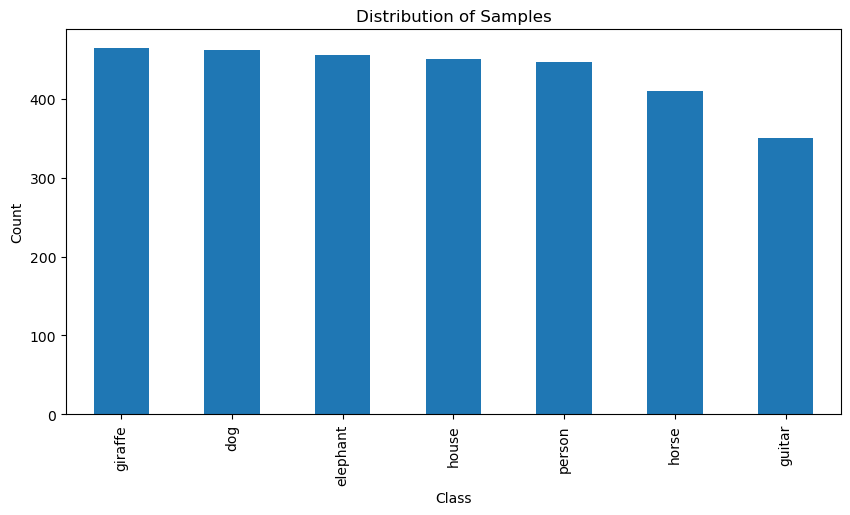

In [41]:
part2_tally_samples(train2_ds)

In [42]:
print(len(train2_ds.image_paths))

3041


Now we can train another classifier using the augmented data:

In [43]:
PART2_SAVE_PATH_2 = "./classify-augmentation" # [Change to your own path]
PART2_LOAD_PATH_2 = './classify-augmentation'
model3, _ = part2_setup(load_path=PART2_LOAD_PATH_2)

# [Call your train function here, training on train2_ds]
if train_type == "part2_train_aug" or train_type == "final":
    part2_train(model3, train2_ds, loss2, n_epochs=10,save_interval = 20, save_path=PART2_SAVE_PATH_2, load_path=PART2_SAVE_PATH_2)


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/10	cross-entropy loss: 0.874	: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!

Accuracy for Train: 0.670
Confusion Matrix for Train: [[340.  49.  18.  14.  17.   5.  10.]
 [223. 143.  20.  21.  13.  14.  19.]
 [ 19.  14. 319.  33.  25.  14.  36.]
 [ 33.  22.  42. 209.  20.   8.  13.]
 [ 14.  20.  33.  21. 283.  15.  21.]
 [ 18.  14.  16.   4.  11. 364.  17.]
 [ 13.  11.  20.  14.   7.  22. 357.]]


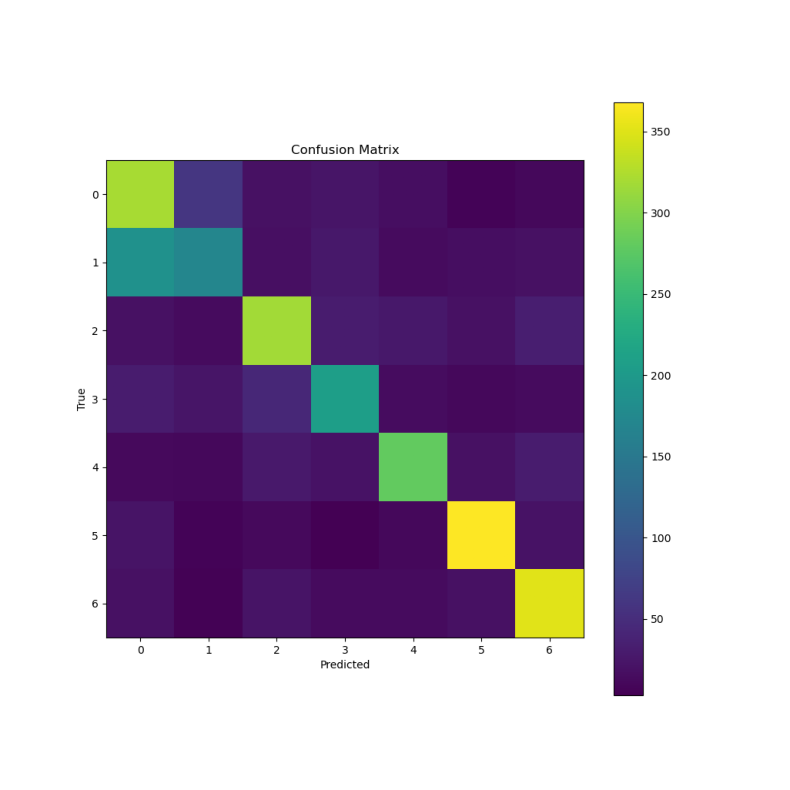

Accuracy for Test: 0.257
Confusion Matrix for Test: [[123.  18.  58.  64.  54.  44.  45.]
 [124.  45.  44.  47.  38.  33.  38.]
 [104.  19. 126.  75.  40.  36.  24.]
 [ 96.  32.  43.  75.  43.  25.  26.]
 [ 97.  36.  41.  42. 103.  37.  26.]
 [ 67.  49.  51.  30.  44. 121.  24.]
 [ 54.  87.  48.  38.  57.  23. 106.]]


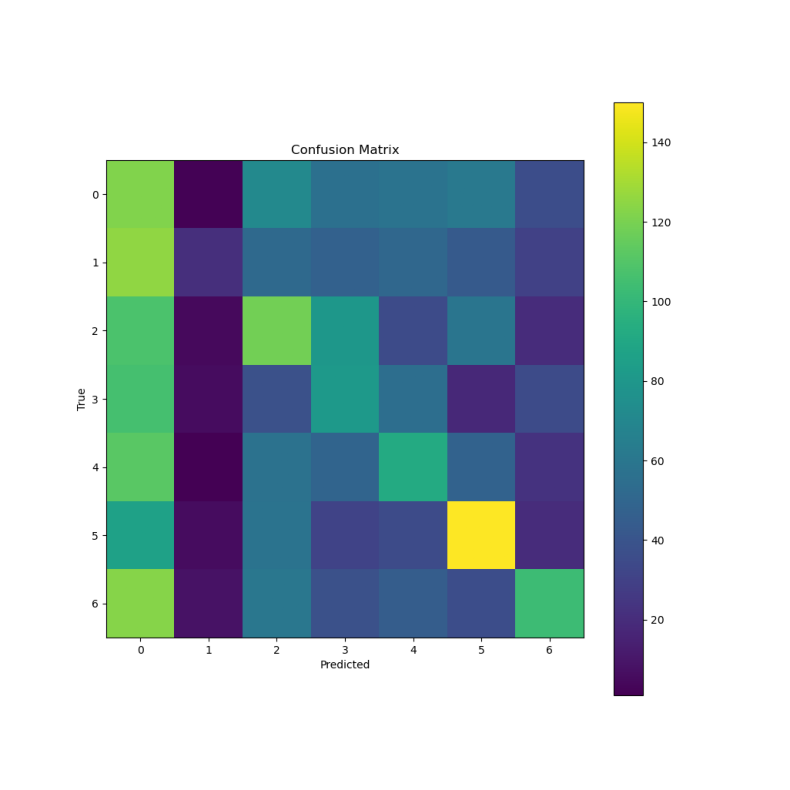

In [48]:
if train_type == "part2_test_aug" or train_type == "final":
    
    accuracies, confusion_matrix = part2_evaluate(model3, train2_ds)
    accuracies_v, confusion_matrix_v = part2_evaluate(model3, test_ds) 

    print(f"Accuracy for Train: {np.mean(accuracies):.3f}")
    print(f"Confusion Matrix for Train: {confusion_matrix}")
    image_path = f'./pic/confusion_matrix_{len(train2_ds)}.png'

    img = plt.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Accuracy for Test: {np.mean(accuracies_v):.3f}")
    print(f"Confusion Matrix for Test: {confusion_matrix_v}")
    image_path_v = f'./pic/confusion_matrix_{len(test_ds)}.png'
    
    img_v = plt.imread(image_path_v)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_v)
    plt.axis('off')
    plt.show()
    
else:
    accuracies = np.load(f'./acc/accuracies_{len(train2_ds)}.npy')
    confusion_matrix = np.load(f'./acc/confusion_matrix.npy_{len(train2_ds)}.npy')
    print(f"Accuracy for Train: {np.mean(accuracies):.3f}")
    print(f"Confusion Matrix for Train: {confusion_matrix}")
    image_path = f'./pic/confusion_matrix_{len(train2_ds)}.png'

    img = plt.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    accuracies = np.load(f'./acc/accuracies_{len(test_ds)}_1.npy')
    confusion_matrix = np.load(f'./acc/confusion_matrix.npy_{len(test_ds)}_1.npy')
    print(f"Accuracy for Test: {np.mean(accuracies):.3f}")
    print(f"Confusion Matrix for Test: {confusion_matrix}")
    image_path_v = f'./pic/confusion_matrix_{len(test_ds)}_1.png'
    
    img_v = plt.imread(image_path_v)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_v)
    plt.axis('off')
    plt.show()
    